# Linear Regression

In [157]:
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt

pd.options.display.max_columns = 1000

%matplotlib inline

In [30]:
dbname = 'nba'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor(buffered = True)

## Preprocessing

### Helper functions

#### Function to convert minutes to seconds

In [24]:
def calc_secs(x):
    return int(x.split(':')[0])*60 + int(x.split(':')[1])

In [25]:
def sql_to_df(table, year=''):
    
    if year:
        year_clean = '00' + year[0] + year[2:]
        select_statement = "select * from nba.{} where (GAME_ID REGEXP '(^{})') order by GAME_ID".format(table, year_clean)
    else:
        select_statement = "SELECT * FROM nba.{} order by GAME_ID;".format(table)
    
    cursor.execute(select_statement)
    data = cursor.fetchall()
    data_df = pd.DataFrame(data)
    
    field_names = [i[0] for i in cursor.description]
    data_df.columns = field_names
    
    return data_df

In [28]:
def join_date(data, year=''):
    date = sql_to_df('game_logs', year)
    
    total_with_date = data.merge(date[['GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION']], on=['GAME_ID', 'TEAM_ABBREVIATION'])
    total_with_date['GAME_DATE'] = total_with_date['GAME_DATE'].astype('datetime64')
    
    players = []

    for player in total_with_date['PLAYER_ID'].unique():
        df = total_with_date[total_with_date['PLAYER_ID']==player]
        df['rest_days'] = df['GAME_DATE'].diff()
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

In [57]:
def join_set_columns(data, year=''):

    vegas = sql_to_df('vegas', year)
    
    total_with_date = data.merge(vegas[['line','total', 'game_id','team','site', 'date']], left_on=['GAME_ID', 'TEAM_ABBREVIATION'], 
                   right_on=['game_id', 'team'])
    
    total_with_date['date'] = total_with_date['date'].astype('datetime64')
    
    players = []

    for player in total_with_date['PLAYER_ID'].unique():
        df = total_with_date[total_with_date['PLAYER_ID']==player].sort_values(by='date')
        df['rest_days'] = df['date'].diff()
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

### Aggregation functions

#### Function to calculate rolling statistics for players from box score data

In [54]:
def formated_player_stats(table, cols, year = '', lag = None):
    
    nba_df = sql_to_df(table, year)
    
    ### Drop games where players do not play
    nba_df_played = nba_df[nba_df['MIN'].notnull()]
    
    ### Calculate seconds played in a game
    nba_df_played['SEC'] = nba_df_played['MIN'].apply(lambda x : calc_secs(x))
    
    
    players = []
    cols = cols
    for player in nba_df_played['PLAYER_ID'].unique():
        df = nba_df_played[nba_df_played['PLAYER_ID']==player]
        df['game_number'] = df['GAME_ID'].expanding().count()
        for col in cols:
            df['expanding_{}'.format(col)] = df.expanding().mean()[col].shift(1)
            if lag:
                df['rolling_{}'.format(col+str(lag))] = df.rolling(lag).mean()[col].shift(1)
        df.dropna(inplace=True)
        players.append(df)
    return pd.concat(players)

#### Function to calculate rolling team statistics

In [ ]:
def formatted_team_stats(table, cols, year = '', lag = None):
    
    pull = sql_to_df(table, year)
    
    teams_df = []
    cols = cols
    ### For every team, calculate the expanding mean for the given columns passed into the function, 
    ### and the the difference between the statistic in the game and the expanding mean leading up to that game
    ### Answers the question "how did a team perform compared to its average going into the game"
    for team in pull['TEAM_ID'].unique():
        df = pull[pull['TEAM_ID']==team]
        df['game_number'] = df['GAME_ID'].expanding().count()
        for col in cols:
            df['expanding_{}'.format(col)] = df.expanding().mean()[col].shift(1)
            df['difference_{}'.format(col)] = df[col] - df['expanding_{}'.format(col)]
            ### Add ability to see how team performs compared to their rolling average over a set of games
            ### Answers question "how did a team perform compared to its average over previous x number of games"
            if lag:
                df['rolling_{}'.format(col+str(lag))] = df.rolling(lag).mean()[col].shift(1)
                df['lag_difference_{}'.format(col)] = df[col] - df['rolling_{}'.format(col+str(lag))]
            continue
        df.dropna(inplace=True)
        teams_df.append(df)
        
        
    return pd.concat(teams_df)

In [159]:
cols = ['SEC', 'FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS']
playerstats_2018 = formated_player_stats('box_score', cols = cols, year='2018')
combined = join_set_columns(playerstats_2018, year='2018')

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [160]:
drop_cols = ['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'SEC', 'game_id', 'game_number', 'team']
pre_transform = combined.drop(drop_cols, axis=1).sort_values(by='date')

In [161]:
pre_transform

,PTS,expanding_SEC,expanding_FGM,expanding_FGA,expanding_FG_PCT,expanding_FG3M,expanding_FG3A,expanding_FG3_PCT,expanding_FTM,expanding_FTA,expanding_FT_PCT,expanding_PTS,line,total,site,date,rest_days
9,10.0,1492.000000,3.500000,8.500000,0.393000,1.500000,2.500000,0.583500,1.000000,1.000000,0.500000,9.500000,-9.0,210.5,away,2018-10-20,1 days
19375,10.0,1121.000000,4.500000,7.000000,0.666500,0.500000,2.000000,0.250000,2.000000,3.000000,0.333500,11.500000,-3.0,219.0,away,2018-10-20,1 days
19376,31.0,1712.000000,3.000000,8.000000,0.366500,1.500000,2.000000,0.750000,2.500000,2.500000,1.000000,10.000000,-3.0,219.0,away,2018-10-20,1 days
19377,5.0,991.500000,2.500000,6.500000,0.393000,1.000000,2.000000,0.250000,0.000000,0.000000,0.000000,6.000000,-3.0,219.0,away,2018-10-20,1 days
19372,28.0,1617.000000,3.000000,9.000000,0.375000,0.000000,1.500000,0.000000,4.000000,4.000000,1.000000,10.000000,-3.0,219.0,away,2018-10-20,1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12526,20.0,1792.566667,7.616667,13.600000,0.557900,0.900000,2.600000,0.292500,3.333333,4.366667,0.701650,19.466667,-2.0,226.0,home,2019-04-10,5 days
12527,7.0,575.297872,1.319149,3.276596,0.318404,0.489362,1.617021,0.204617,0.510638,0.702128,0.234064,3.638298,-2.0,226.0,home,2019-04-10,3 days
20567,2.0,433.000000,1.333333,2.666667,0.404833,0.500000,1.000000,0.166667,0.333333,0.333333,0.166667,3.500000,5.0,229.0,away,2019-04-10,22 days
12528,2.0,864.625000,1.875000,2.750000,0.506250,0.000000,0.125000,0.000000,0.500000,1.000000,0.250000,4.250000,-2.0,226.0,home,2019-04-10,3 days


In [162]:
pre_transform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25054 entries, 9 to 6048
Data columns (total 17 columns):
PTS                  25054 non-null float64
expanding_SEC        25054 non-null float64
expanding_FGM        25054 non-null float64
expanding_FGA        25054 non-null float64
expanding_FG_PCT     25054 non-null float64
expanding_FG3M       25054 non-null float64
expanding_FG3A       25054 non-null float64
expanding_FG3_PCT    25054 non-null float64
expanding_FTM        25054 non-null float64
expanding_FTA        25054 non-null float64
expanding_FT_PCT     25054 non-null float64
expanding_PTS        25054 non-null float64
line                 25054 non-null float64
total                25054 non-null float64
site                 25054 non-null object
date                 25054 non-null datetime64[ns]
rest_days            25054 non-null timedelta64[ns]
dtypes: datetime64[ns](1), float64(14), object(1), timedelta64[ns](1)
memory usage: 3.4+ MB


In [163]:
pre_transform['rest_days'] = pre_transform['rest_days'].dt.days

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



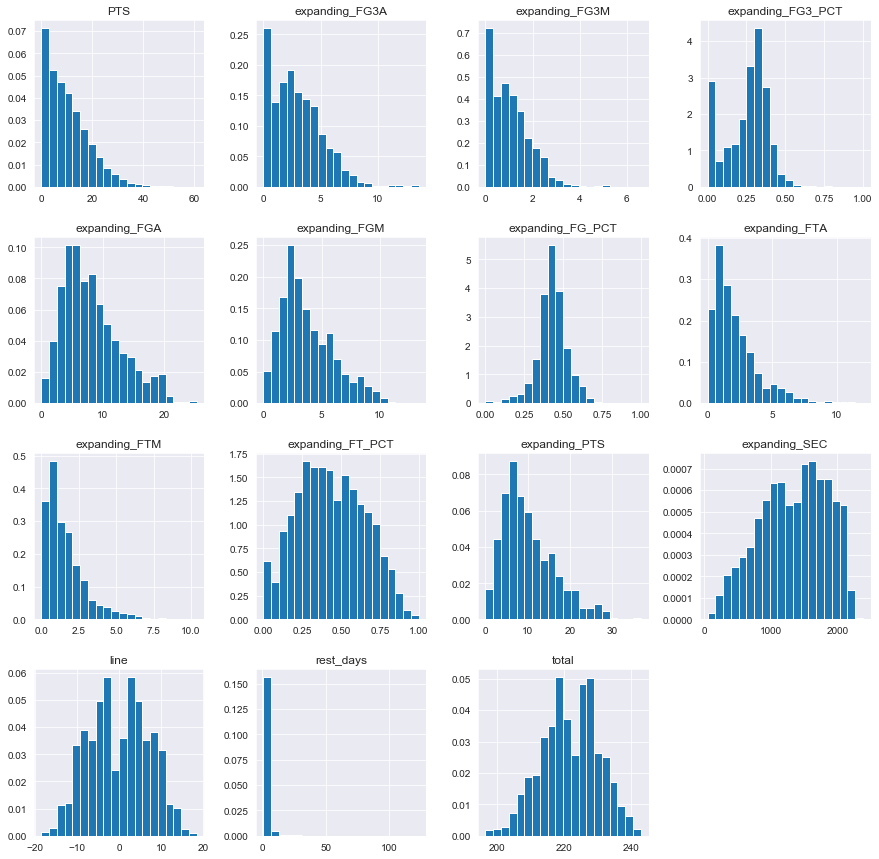

In [164]:

fig = plt.figure(figsize=(15,15))
ax = fig.gca()
pre_transform.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);


### Select only 2/3 of the season to build the model and transform the variables on. Test on the end of the season

In [167]:
train_size = int(round(combined.shape[0]*(2/3),0))
test_size = int(round(combined.shape[0]*(1/3),0))

train_size + test_size

25054

In [204]:
def do_regression(df, vars_to_transform):
    
    train = df.iloc[:train_size, :]
    test = df.iloc[:test_size, :]
    
    train_copy = train.copy()

    variables_to_transfrom = vars_to_transform
    scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
    
    train_copy[variables_to_transfrom] = scaler.fit_transform(train[variables_to_transfrom])
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca()
    train_copy.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);
    
    corr_train = train_copy.corr()
    fig = plt.figure(figsize = (15, 12))
    ax = fig.gca()
    sns.heatmap(corr_train, ax = ax)
    
    outcome = 'PTS'
    predictors = train_copy.drop(labels=['PTS', 'date'], axis=1)
    pred_sum = "+".join(predictors.columns)
    formula = outcome + "~" + pred_sum
    
    model = ols(formula=formula, data=train_expanding_only.drop('date', axis=1)).fit()
    
    print(model.summary2())
    
    test_expanding_only = test.copy()
    test_expanding_only[variables_to_transfrom] = scaler.transform(test[variables_to_transfrom])
    
    prediction = pd.DataFrame(model.predict(test_expanding_only))
    merged = prediction.merge(test_expanding_only[['PTS']], left_on=prediction.index, right_on=test_expanding_only.index)
    merged.index = merged['key_0']
    merged.drop('key_0', axis=1, inplace=True)
    
    y_pred_df = prediction.merge(test_expanding_only.drop('PTS', axis=1), 
                 left_on= prediction.index, right_on= test_expanding_only.index).set_index('key_0', drop=True)
    
    y_pred_df.columns = ['PTS' if x == 0 else x for x in y_pred_df.columns ]
    y_pred_reg = y_pred_df.copy()
    
    y_pred_reg.columns = ['PTS' if x == 0 else x for x in y_pred_reg.columns ]
    
    y_pred_reg[variables_to_transfrom] = scaler.inverse_transform(y_pred_df[variables_to_transfrom])
    
    print(sqrt(mean_squared_error(test.PTS, y_pred_reg.PTS)))


/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.475     
Dependent Variable: PTS              AIC:                36649.1287
Date:               2020-01-15 17:32 BIC:                36772.7022
No. Observations:   16703            Log-Likelihood:     -18309.   
Df Model:           15               F-statistic:        1009.     
Df Residuals:       16687            Prob (F-statistic): 0.00      
R-squared:          0.476            Scale:              0.52484   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.2092   0.1558 -1.3433 0.1792 -0.5146  0.0961
site[T.home]         0.0215   0.0122  1.7594 0.0785 -0.0025  0.0455
expanding_SEC        0.0740   0.0138  5.3433 0.0000  0.0468  0.1011
expanding_FGM        0.5534   0.0926  5.9764 0.0000  0.3719  0.734

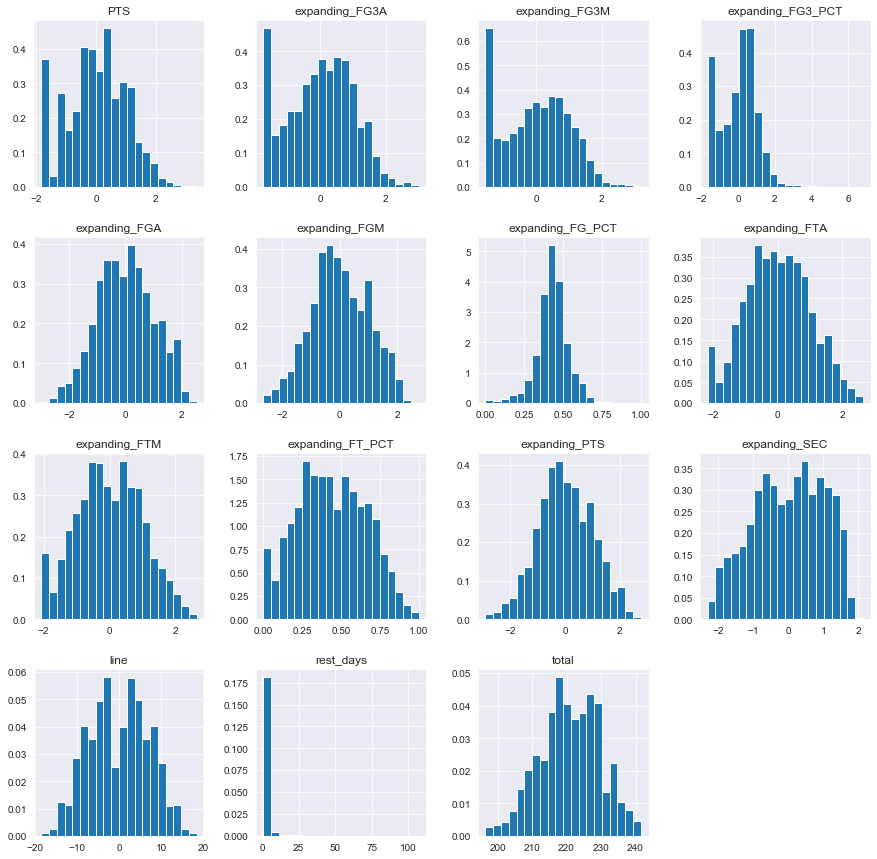

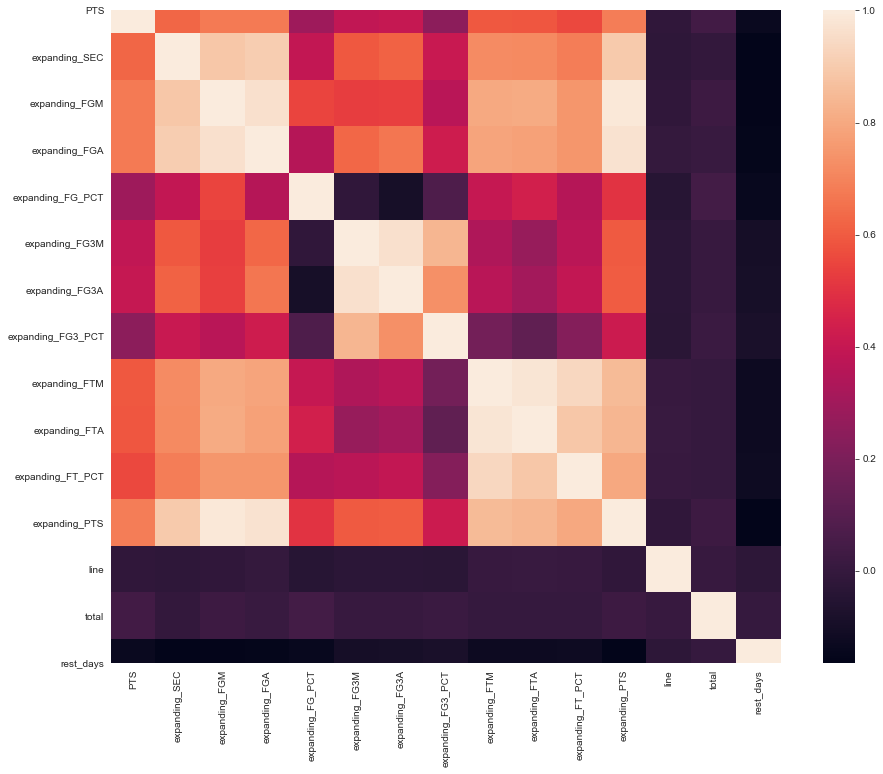

In [205]:
do_regression(pre_transform, ['PTS', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FGM', 'expanding_FGA','expanding_FTM', 'expanding_FTA','expanding_SEC', 'expanding_PTS'])

In [168]:
train = pre_transform.iloc[:train_size, :]
test = pre_transform.iloc[:test_size, :]

In [169]:
train.shape[0]+ test.shape[0]

25054

### Transform training variable to be more normal

In [170]:
pre_transform.columns

Index(['PTS', 'expanding_SEC', 'expanding_FGM', 'expanding_FGA',
       'expanding_FG_PCT', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FTM', 'expanding_FTA',
       'expanding_FT_PCT', 'expanding_PTS', 'line', 'total', 'site', 'date',
       'rest_days'],
      dtype='object')

In [171]:
train_expanding_only = train.copy()

variables_to_transfrom = ['PTS', 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FGM', 'expanding_FGA','expanding_FTM', 'expanding_FTA','expanding_SEC', 'expanding_PTS']

scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
train_expanding_only[variables_to_transfrom] = scaler.fit_transform(train[variables_to_transfrom])


/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



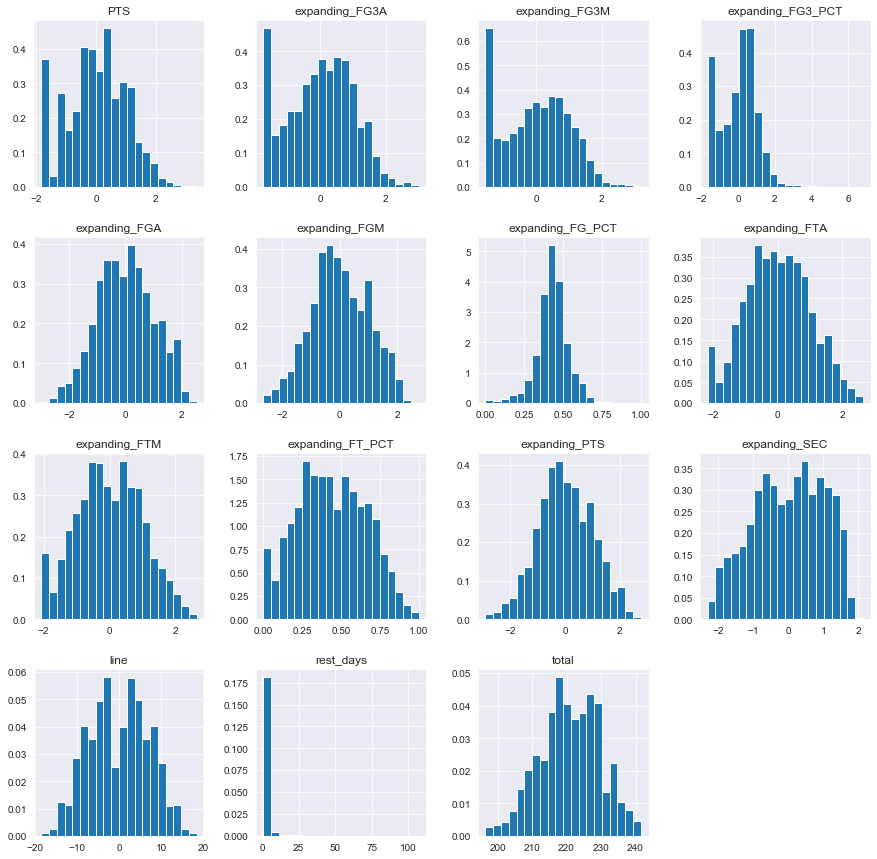

In [172]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
train_expanding_only.drop('date', axis=1).hist(ax = ax, normed=True, bins=20);


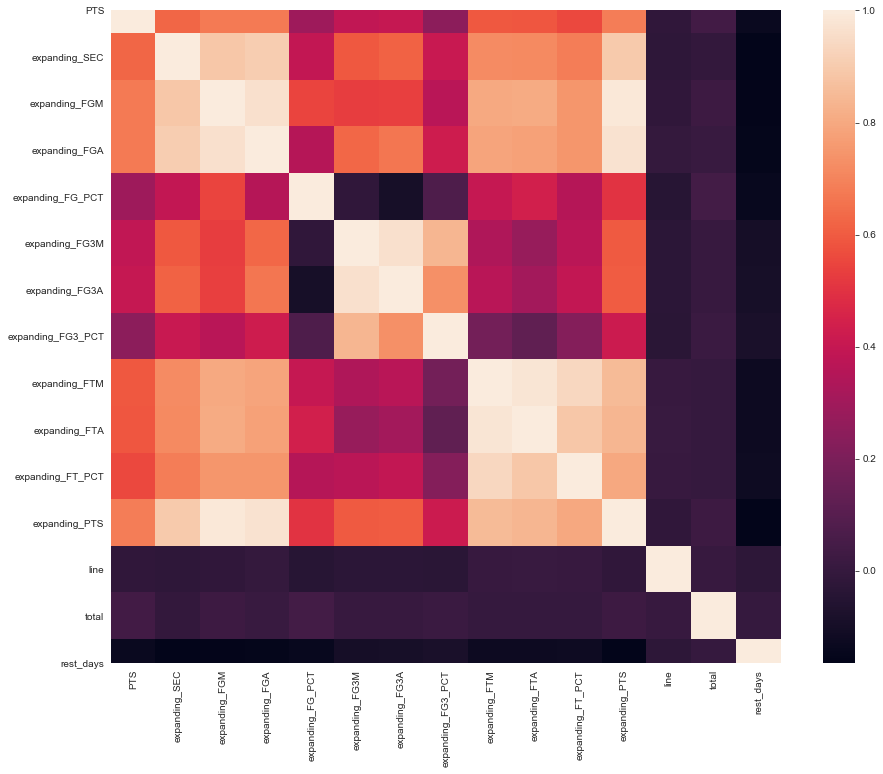

In [173]:
corr_train = train_expanding_only.corr()
fig = plt.figure(figsize = (15, 12))
ax = fig.gca()
sns.heatmap(corr_train, ax = ax)

In [174]:
outcome = 'PTS'
predictors = train_expanding_only.drop(labels=['PTS', 'date'], axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [175]:
formula

'PTS~expanding_SEC+expanding_FGM+expanding_FGA+expanding_FG_PCT+expanding_FG3M+expanding_FG3A+expanding_FG3_PCT+expanding_FTM+expanding_FTA+expanding_FT_PCT+expanding_PTS+line+total+site+rest_days'

In [176]:
model = ols(formula=formula, data=train_expanding_only.drop('date', axis=1)).fit()

In [177]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.475     
Dependent Variable: PTS              AIC:                36649.1287
Date:               2020-01-15 16:52 BIC:                36772.7022
No. Observations:   16703            Log-Likelihood:     -18309.   
Df Model:           15               F-statistic:        1009.     
Df Residuals:       16687            Prob (F-statistic): 0.00      
R-squared:          0.476            Scale:              0.52484   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -0.2092   0.1558 -1.3433 0.1792 -0.5146  0.0961
site[T.home]         0.0215   0.0122  1.7594 0.0785 -0.0025  0.0455
expanding_SEC        0.0740   0.0138  5.3433 0.0000  0.0468  0.1011
expanding_FGM        0.5534   0.0926  5.9764 0.0000  0.3719  0.7349
expanding_FGA       -0.1433   0.0484 -2.9635 0.0030 -0.2381 -0.0485
expanding_FG_PCT    -1.0812   0.1179 -9.1724 0.0000 -1.3123 -0.8502
expanding_FG3M      -0.0238   0.0381 -0.6252 0.5319 -0.0986  0.0509
expanding_FG3A       0.0463   0.0316  1.4666 0.1425 -0.0156  0.1081
expanding_FG3_PCT   -0.0260   0.0127 -2.0564 0.0398 -0.0508 -0.0012
expanding_FTM        0.1233   0.0477  2.5852 0.0097  0.0298  0.2168
expanding_FTA       -0.0215   0.0325 -0.6620 0.5079 -0.0851  0.0421
expanding_FT_PCT    -0.0167   0.0812 -0.2062 0.8366 -0.1759  0.1424
expanding_PTS        0.1706   0.1161  1.4689 0.1419 -0.0570  0.3982
line                -0.0008   0.0009 -0.9309 0.3519 -0.0025  0.0009
total                0.0031   0.0006  4.8588 0.0000  0.0019  0.0044
rest_days           -0.0093   0.0016 -5.7864 0.0000 -0.0124 -0.0061
-------------------------------------------------------------------
Omnibus:              137.391       Durbin-Watson:          1.997  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       140.691
Skew:                 -0.225        Prob(JB):               0.000  
Kurtosis:             2.991         Condition No.:          6665   
===================================================================
* The condition number is large (7e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [178]:
test_expanding_only = test.copy()
test_expanding_only[variables_to_transfrom] = scaler.transform(test[variables_to_transfrom])

In [179]:
prediction = pd.DataFrame(model.predict(test_expanding_only))
merged = prediction.merge(test_expanding_only[['PTS']], left_on=prediction.index, right_on=test_expanding_only.index)
merged.index = merged['key_0']
merged.drop('key_0', axis=1, inplace=True)

In [180]:
test_expanding_only

,PTS,expanding_SEC,expanding_FGM,expanding_FGA,expanding_FG_PCT,expanding_FG3M,expanding_FG3A,expanding_FG3_PCT,expanding_FTM,expanding_FTA,expanding_FT_PCT,expanding_PTS,line,total,site,date,rest_days
9,0.173634,0.270981,0.071654,0.240242,0.393000,0.727490,0.008046,2.611299,-0.276598,-0.607847,0.500000,0.080709,-9.0,210.5,away,2018-10-20,1
19375,0.173634,-0.463257,0.494247,-0.084419,0.666500,-0.509429,-0.244688,-0.061394,0.579827,0.748564,0.333500,0.391812,-3.0,219.0,away,2018-10-20,1
19376,1.882673,0.718761,-0.169357,0.136375,0.366500,0.727490,-0.244688,4.170807,0.873317,0.502637,1.000000,0.162195,-3.0,219.0,away,2018-10-20,1
19377,-0.522444,-0.712322,-0.436473,-0.202288,0.393000,0.195755,-0.244688,-0.061394,-2.072044,-2.180756,0.000000,-0.585163,-3.0,219.0,away,2018-10-20,1
19372,1.693636,0.524377,-0.169357,0.340274,0.375000,-1.542221,-0.528066,-1.667433,1.491808,1.144192,1.000000,0.162195,-3.0,219.0,away,2018-10-20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9047,0.052970,0.294825,0.656233,0.450313,0.512536,-0.031044,0.008046,0.216558,0.854302,0.812037,0.664929,0.621779,5.0,202.0,home,2018-12-15,1
16098,0.052970,0.606180,0.291626,0.498264,0.410034,1.125625,1.320946,0.434020,0.624153,0.651591,0.520414,0.468875,-5.5,205.5,away,2018-12-15,3
3804,0.499795,1.400263,1.706120,1.839797,0.446737,0.378300,1.030446,-0.412481,1.327308,1.644215,0.593474,1.565995,-6.5,222.5,home,2018-12-15,1
292,-0.904083,0.078884,-0.063204,0.181382,0.378107,0.659154,0.588223,0.715229,-0.447424,-0.429427,0.366071,-0.053115,-2.0,215.0,away,2018-12-15,1


In [181]:
y_pred_df = prediction.merge(test_expanding_only.drop('PTS', axis=1), 
                 left_on= prediction.index, right_on= test_expanding_only.index).set_index('key_0', drop=True)

In [183]:
y_pred_reg = y_pred_df.copy()

variables_to_transfrom = [0, 'expanding_FG3M', 'expanding_FG3A',
       'expanding_FG3_PCT', 'expanding_FGM', 'expanding_FGA','expanding_FTM', 'expanding_FTA','expanding_SEC', 'expanding_PTS']
y_pred_reg[variables_to_transfrom] = scaler.inverse_transform(y_pred_df[variables_to_transfrom])

In [192]:
y_pred_reg.columns

Index([                  0,     'expanding_SEC',     'expanding_FGM',
           'expanding_FGA',  'expanding_FG_PCT',    'expanding_FG3M',
          'expanding_FG3A', 'expanding_FG3_PCT',     'expanding_FTM',
           'expanding_FTA',  'expanding_FT_PCT',     'expanding_PTS',
                    'line',             'total',              'site',
                    'date',         'rest_days'],
      dtype='object')

In [196]:
['PTS' if x == 0 else x for x in y_pred_reg.columns ]

['PTS',
 'expanding_SEC',
 'expanding_FGM',
 'expanding_FGA',
 'expanding_FG_PCT',
 'expanding_FG3M',
 'expanding_FG3A',
 'expanding_FG3_PCT',
 'expanding_FTM',
 'expanding_FTA',
 'expanding_FT_PCT',
 'expanding_PTS',
 'line',
 'total',
 'site',
 'date',
 'rest_days']

In [184]:
y_pred_reg

,0,expanding_SEC,expanding_FGM,expanding_FGA,expanding_FG_PCT,expanding_FG3M,expanding_FG3A,expanding_FG3_PCT,expanding_FTM,expanding_FTA,expanding_FT_PCT,expanding_PTS,line,total,site,date,rest_days
key_0,,,,,,,,,,,,,,,,,
9,8.191649,1492.000000,3.500000,8.500000,0.393000,1.500000,2.500000,0.583500,1.000000,1.000000,0.500000,9.500000,-9.0,210.5,away,2018-10-20,1
19375,9.563066,1121.000000,4.500000,7.000000,0.666500,0.500000,2.000000,0.250000,2.000000,3.000000,0.333500,11.500000,-3.0,219.0,away,2018-10-20,1
19376,8.471687,1712.000000,3.000000,8.000000,0.366500,1.500000,2.000000,0.750000,2.500000,2.500000,1.000000,10.000000,-3.0,219.0,away,2018-10-20,1
19377,4.891023,991.500000,2.500000,6.500000,0.393000,1.000000,2.000000,0.250000,0.000000,0.000000,0.000000,6.000000,-3.0,219.0,away,2018-10-20,1
19372,10.130137,1617.000000,3.000000,9.000000,0.375000,0.000000,1.500000,0.000000,4.000000,4.000000,1.000000,10.000000,-3.0,219.0,away,2018-10-20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9047,11.829520,1503.821429,4.928571,9.571429,0.512536,0.821429,2.500000,0.288536,2.464286,3.142857,0.664929,13.142857,5.0,202.0,home,2018-12-15,1
16098,10.767048,1657.068966,4.000000,9.827586,0.410034,1.965517,6.034483,0.317931,2.068966,2.793103,0.520414,12.034483,-5.5,205.5,away,2018-12-15,3
3804,21.563061,2039.736842,8.421053,18.947368,0.446737,1.157895,5.105263,0.199632,3.526316,5.736842,0.593474,21.526316,-6.5,222.5,home,2018-12-15,1


In [185]:
test

,PTS,expanding_SEC,expanding_FGM,expanding_FGA,expanding_FG_PCT,expanding_FG3M,expanding_FG3A,expanding_FG3_PCT,expanding_FTM,expanding_FTA,expanding_FT_PCT,expanding_PTS,line,total,site,date,rest_days
9,10.0,1492.000000,3.500000,8.500000,0.393000,1.500000,2.500000,0.583500,1.000000,1.000000,0.500000,9.500000,-9.0,210.5,away,2018-10-20,1
19375,10.0,1121.000000,4.500000,7.000000,0.666500,0.500000,2.000000,0.250000,2.000000,3.000000,0.333500,11.500000,-3.0,219.0,away,2018-10-20,1
19376,31.0,1712.000000,3.000000,8.000000,0.366500,1.500000,2.000000,0.750000,2.500000,2.500000,1.000000,10.000000,-3.0,219.0,away,2018-10-20,1
19377,5.0,991.500000,2.500000,6.500000,0.393000,1.000000,2.000000,0.250000,0.000000,0.000000,0.000000,6.000000,-3.0,219.0,away,2018-10-20,1
19372,28.0,1617.000000,3.000000,9.000000,0.375000,0.000000,1.500000,0.000000,4.000000,4.000000,1.000000,10.000000,-3.0,219.0,away,2018-10-20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9047,9.0,1503.821429,4.928571,9.571429,0.512536,0.821429,2.500000,0.288536,2.464286,3.142857,0.664929,13.142857,5.0,202.0,home,2018-12-15,1
16098,9.0,1657.068966,4.000000,9.827586,0.410034,1.965517,6.034483,0.317931,2.068966,2.793103,0.520414,12.034483,-5.5,205.5,away,2018-12-15,3
3804,13.0,2039.736842,8.421053,18.947368,0.446737,1.157895,5.105263,0.199632,3.526316,5.736842,0.593474,21.526316,-6.5,222.5,home,2018-12-15,1
292,3.0,1396.285714,3.214286,8.214286,0.378107,1.428571,3.857143,0.355036,0.857143,1.178571,0.366071,8.714286,-2.0,215.0,away,2018-12-15,1


In [190]:
sqrt(mean_squared_error(test.PTS, y_pred_reg[0]))

5.931777754799309

In [189]:
sqrt(mean_squared_error(test.PTS, test.expanding_PTS))

5.9590763547667835

[0,
 'expanding_FG3M',
 'expanding_FG3A',
 'expanding_FG3_PCT',
 'expanding_FGM',
 'expanding_FGA',
 'expanding_FTM',
 'expanding_FTA',
 'expanding_SEC',
 'expanding_PTS']